In [75]:
import numpy as np
import matplotlib.pyplot as plt

import nengo
from nengo.dists import Uniform
from nengo.processes import WhiteSignal
from nengo.utils.ensemble import tuning_curves
from nengo.utils.ipython import hide_input
from nengo.utils.matplotlib import rasterplot

hide_input()

# Custom dendrites
In a `given` ensemble, we show that custom dendrites can be used to hear different things from the ensemble's spiking. The combination of `given` and $n$ custom dendrites represent a $n$-dimensional vector.


In [76]:
model = nengo.Network(seed=0)

with model:

    n_neurons = 32
    # Let the `given` ensemble have n_neurons neurons
    given = nengo.Ensemble(
        n_neurons=n_neurons,
        dimensions=2,
    )

    # Some stimulus is needed to let `given` spike
    cos = nengo.Node(lambda t: np.sin(2*np.pi*t))
    # perform walk on tuning curve landscpe
    nengo.Connection(cos, given[0])
    nengo.Connection(nengo.Node(lambda t : np.cos(2*np.pi* t)), given[1])
    # nengo.Connection(nengo.Node(lambda t : np.cos(np.pi*t/2)), given[2])

    # Create dummy ensemble to read dendrite weights
    dummy = nengo.Ensemble(64,dimensions=3,)

    # The 3 dendrites will generate soma currents:
    # cos(8t)
    conn0 = nengo.Connection(given[0], dummy[0], function=lambda x : x)
    # cos^2(8t)
    conn1 = nengo.Connection(given[0], dummy[1], function=lambda x : x ** 2)
    # 0.5
    conn2 = nengo.Connection(given[0], dummy[2], function=lambda x : 0.5)

    D_spikes = nengo.Probe(given.neurons)
    D_PSC = nengo.Probe(given.neurons, synapse=0.01)

In [77]:
with nengo.Simulator(model) as sim:
    sim.run(1)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

# The given spiking activity

The spiking activity manifests from the tuning curves of the ensemble and the driving function. In this juptyer, we mostly throw those things under the hood and just work with these spikes.

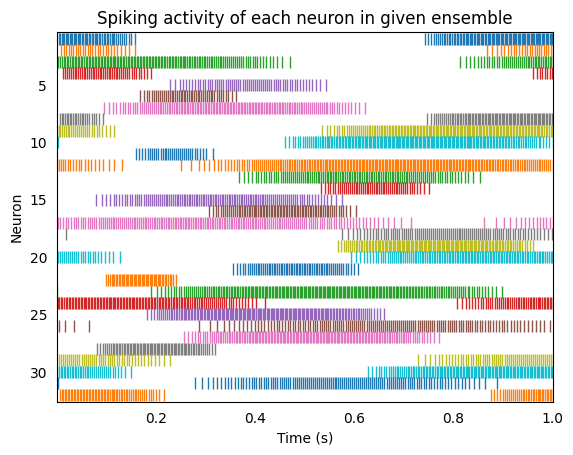

In [78]:
rasterplot(sim.trange(), sim.data[D_spikes])
plt.ylabel("Neuron")
plt.xlabel("Time (s)")
plt.title('Spiking activity of each neuron in given ensemble')
plt.show()


# What do the dendrites look like?

Each dendrite is an array of length `n_neurons`. Each neuron in `given` corresponds to an array element, its assigned weight.
- Large (small) weight magnitude signifies:
   - high (low) synaptic strength
   - synapse close to (far from) soma
- Positive (negative) weight signifies excitatory (inhibitory) connection

We do principle neuron analysis by looking at highest weights. (I suggest including all neurons first and then cutting down.)

[-1.56561554e-04  2.05389690e-05  5.53623505e-04  1.64828893e-04
  4.17814185e-04  2.26510872e-04  3.00857544e-04 -3.29627140e-04
 -2.67400962e-04 -5.09008501e-04  4.98245386e-05 -4.26856205e-04
 -1.90803605e-04 -1.94603248e-04  4.17630662e-04  1.03571634e-04
  5.99011188e-04 -2.36747748e-04 -2.85414185e-04 -1.04385290e-04
 -7.03253037e-05 -1.34866493e-06 -2.98620049e-05  4.77625576e-04
  2.53558052e-04 -3.68930645e-04  1.48899205e-05  2.69807111e-04
 -2.20467519e-05 -1.04423533e-04 -1.95811185e-04  1.87763473e-04]


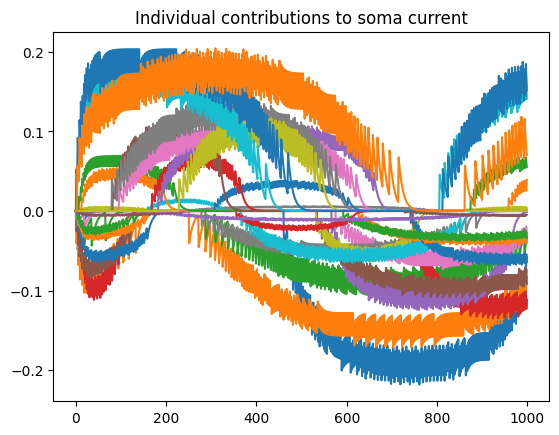

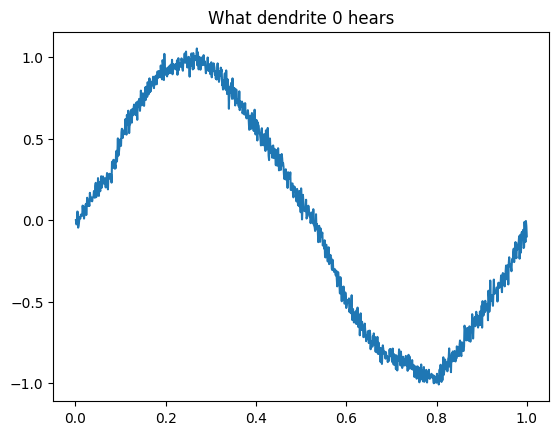

[-1.60394848e-04 -1.78105318e-04 -2.08599753e-05  1.59295459e-04
  4.11419732e-04  5.21114577e-04  5.04416518e-04 -6.70605385e-05
  7.77748876e-05 -1.08429340e-04  1.35209065e-04 -5.54470268e-04
  2.68928285e-04  3.73699487e-04  7.54010190e-04 -1.39116138e-04
 -1.69120642e-04  5.97170559e-04  1.12005142e-03  2.71738184e-04
 -3.00050140e-04  8.54688457e-05  2.65812962e-04  3.07076198e-04
  7.49947684e-05 -3.41421418e-04 -1.18188083e-04  6.98108603e-04
 -5.00783086e-05  2.95099814e-04 -9.52669147e-06  1.42968805e-05]


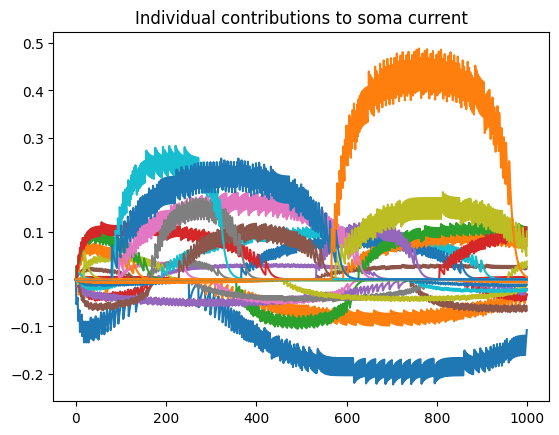

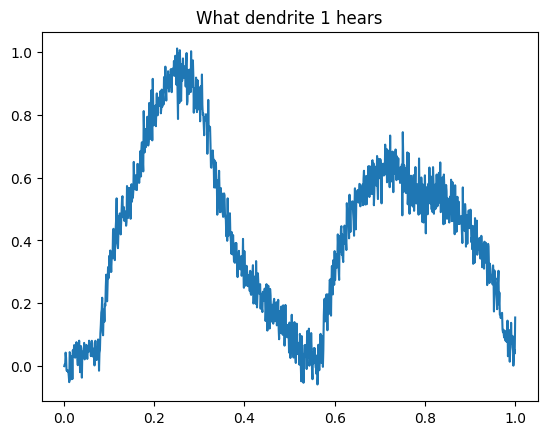

[ 1.06436303e-05  4.48131943e-06  2.75731737e-04  4.91435245e-05
 -8.23616686e-05 -1.42284444e-07  2.01202206e-04 -6.59842096e-05
  1.61298933e-04  8.79122902e-05  1.28838871e-05  3.08330876e-04
  1.76064764e-04 -1.99502098e-05  1.68186192e-04 -4.17433878e-05
  3.58820362e-04  2.90344891e-06  5.68500097e-05  8.53774827e-05
  9.88938328e-06  1.56532639e-05  2.76467328e-04  2.82199076e-04
  1.83629793e-05  1.41401676e-04  6.52155023e-05  9.20155722e-05
  1.62394691e-04  1.10796883e-04  8.66868521e-05  1.34191513e-04]


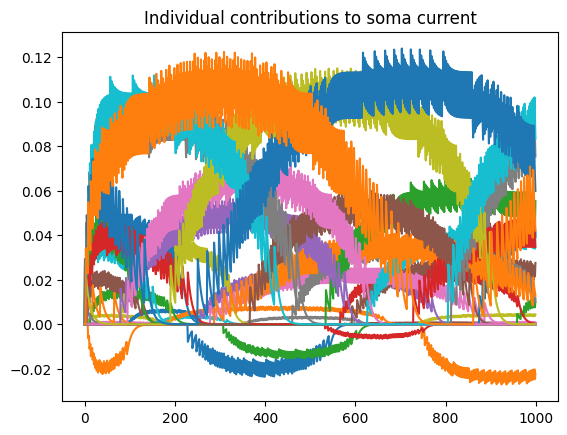

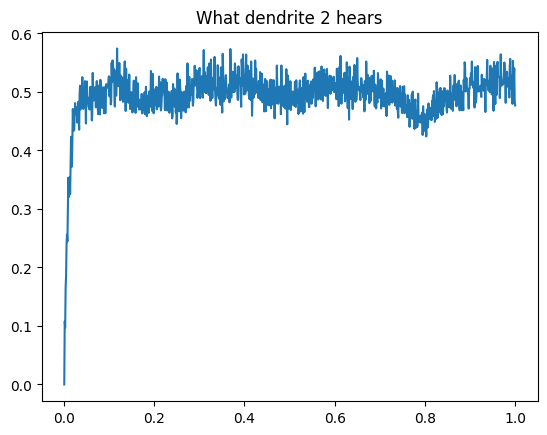

In [79]:
# number of principle neurons to include
n = 32

conns = [conn0,conn1,conn2]
# for each dimension
for d in range(3):
    # coax weights out of nengo
    dendrite = sim.data[conns[d]].weights[0]  # a connection can only have one set of weights but it's double-wrapped

    print(dendrite)

    # identify primary neurons
    primary_components = np.argsort(dendrite)[:n]

    # resulting soma current
    sum = np.zeros(sim.trange().shape)

    # identify individual contribution = weight * post-synaptic current if onehot
    for neuron in primary_components:
        contrib = dendrite[neuron] * sim.data[D_PSC][:, neuron]
        plt.plot(contrib)
        sum += contrib
    plt.title('Individual contributions to soma current')
    plt.show()

    # the resulting soma current should be magical
    plt.plot(sim.trange(), sum)
    plt.title(f'What dendrite {d} hears')
    plt.show()

# Conclusion
Dendrites 0, 1, and 2 respectively heard $\cos(8t),\cos ^{2}(8t),0.5$.

Dendrite 0's job was particularly easy because we used a $\cos(8t)$ to poke the `given` ensemble. Dendrite 2 did reasonably well!

In [80]:
given.encoders

ScatteredHypersphere(surface=True)